In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
dfr = pd.read_csv('data/YelpReview.csv')

In [3]:
print(len(dfr))
dfr = dfr.dropna(subset=['business_id', 'stars','clean_text'])
print(len(dfr))

4747892
4747852


In [4]:
corpus = list(dfr.clean_text)
y      = list(dfr.sentiment)
del dfr

# TF-IDF Vectorization

In [5]:
tfidf = TfidfVectorizer(max_features=10000)

start_time = time.time()
X_raw = tfidf.fit_transform(corpus)
y_raw = y
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(tfidf, 'models/TFIDF_model.joblib')
del corpus

--- 239.5211718082428 seconds ---


In [6]:
print(X_raw.shape)
# print(tfidf.get_feature_names())

(4747852, 10000)


# Split data into training and test samples

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.5, random_state=88)
del X_raw, y_raw

# Dimension reduction via Truncated SVD

In [8]:
svd = TruncatedSVD(n_components=300)

start_time = time.time()
X_train_svd = svd.fit_transform(X_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(svd, 'models/SVD_model.joblib')

start_time = time.time()
X_test_svd = svd.transform(X_test)
print('--- {0} seconds ---'.format( time.time() - start_time ))

# print(svd.explained_variance_ratio_)  
# print(svd.explained_variance_ratio_.sum())  
# print(svd.singular_values_)

del X_train

--- 942.6050789356232 seconds ---
--- 28.489117860794067 seconds ---


Text(0.5, 0, 'Singular Value count')

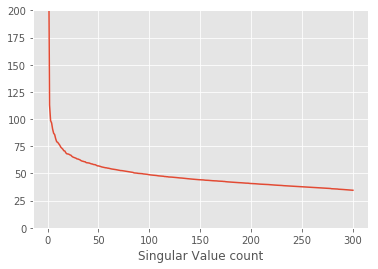

In [9]:
fig, ax = plt.subplots()
svs_ = svd.singular_values_
ax.plot(range(1,len(svs_)+1), svs_, '-')
plt.ylim([0,200])
plt.xlabel('Singular Value count')

# Logistic Regression classification

In [10]:
logreg = LogisticRegression(random_state=34, solver='lbfgs')

start_time = time.time()
logreg.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(logreg, 'models/LogReg_model.joblib')

--- 92.89965176582336 seconds ---


['models/LogReg_model.joblib']

In [11]:
start_time = time.time()
y_pred = logreg.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_svd, y_test)))

--- 19.745219945907593 seconds ---
Accuracy of logistic regression classifier on test set: 0.87


In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[ 638089  177944]
 [ 122687 1435206]]


# Gaussian Naive Bayes classifier

In [13]:
gnb = GaussianNB()

start_time = time.time()
gnb.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(gnb, 'models/GNB_model.joblib')

--- 58.02154588699341 seconds ---


['models/GNB_model.joblib']

In [14]:
start_time = time.time()
y_pred = gnb.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Gaussian Naive Bayes classifier on test set: {:.2f}'.format(gnb.score(X_test_svd, y_test)))

--- 117.09749507904053 seconds ---
Accuracy of Gaussian Naive Bayes classifier on test set: 0.68


In [15]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[ 602273  213760]
 [ 535343 1022550]]


# Linear Support Vector Machine 

In [16]:
lsvm = LinearSVC(random_state=845, tol=1e-5)

start_time = time.time()
lsvm.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(lsvm, 'models/LSVM_model.joblib')

--- 316.4190351963043 seconds ---


['models/LSVM_model.joblib']

In [17]:
start_time = time.time()
y_pred = lsvm.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Linear SVM classifier on test set: {:.2f}'.format(lsvm.score(X_test_svd, y_test)))

--- 20.215735912322998 seconds ---
Accuracy of Linear SVM classifier on test set: 0.87


In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[ 635821  180212]
 [ 120709 1437184]]


# Random Forest classifier

In [10]:
# rfc = RandomForestClassifier(n_estimators=30, max_depth=30, random_state=214)
rfc = RandomForestClassifier(n_estimators=10)

start_time = time.time()
rfc.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(rfc, 'models/RFC_model.joblib')

--- 571.137711763382 seconds ---


['models/RFC_model.sav']

In [11]:
start_time = time.time()
y_pred = rfc.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc.score(X_test_svd, y_test)))

--- 82.608647108078 seconds ---
Accuracy of Random Forest classifier on test set: 0.79


In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[ 820610  402859]
 [ 335634 2001786]]
